In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_plot, backtest_stats

from pprint import pprint

c:\users\gary1\fyp\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
config.DOW_30_TICKER

In [20]:
df = YahooDownloader(start_date = '2014-01-01',
                     end_date = '2020-01-01',
                     ticker_list = ['AAPL', 'MSFT', 'JPM']).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4533, 8)


In [21]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


In [22]:
processed['log_volume'] = np.log(processed.volume*processed.close)
processed['change'] = (processed.close-processed.open)/processed.close
processed['daily_variance'] = (processed.high-processed.low)/processed.close
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2013-12-31,19.791786,20.045713,19.785713,17.849323,223084400,AAPL,1,0.000000,18.078815,17.368806,0.000000,-66.666667,100.0,17.849323,17.849323,22.105026,-0.108826,0.014566
1,2013-12-31,58.200001,58.549999,58.049999,47.547234,11017400,JPM,1,-0.005632,18.078815,17.368806,0.000000,-66.666667,100.0,17.723810,17.723810,20.076710,-0.224046,0.010516
2,2013-12-31,37.400002,37.580002,37.220001,32.272999,17503500,MSFT,1,-0.019164,18.195491,16.910746,0.000000,-100.000000,100.0,17.553118,17.553118,20.152142,-0.158864,0.011155
3,2014-01-02,19.845715,19.893929,19.715000,17.598297,234684800,AAPL,3,-0.021460,18.071206,16.911269,13.368176,-86.182823,100.0,17.491237,17.491237,22.141556,-0.127707,0.010167
4,2014-01-02,58.310001,58.500000,57.970001,47.637249,15627600,JPM,3,-0.027180,18.002818,16.855893,11.306408,-68.445350,100.0,17.429356,17.429356,20.428164,-0.224042,0.011126


In [7]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2,0.000000,2.943609,2.473751,100.000000,66.666667,100.000000,2.625620,2.625620,21.190248,-0.169384,0.032645
1,2008-12-31,17.969999,18.750000,17.910000,15.064775,9625600,AXP,2,0.003727,2.943609,2.473751,100.000000,66.666667,100.000000,2.708680,2.708680,18.792296,-0.192849,0.055759
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,0.008403,3.060949,2.490333,100.000000,100.000000,100.000000,2.775641,2.775641,18.975780,-0.299448,0.048429
3,2008-12-31,43.700001,45.099998,43.700001,31.403988,6277400,CAT,2,0.008591,3.045421,2.548827,84.866792,64.367902,100.000000,2.797124,2.797124,19.099401,-0.391543,0.044580
4,2008-12-31,16.180000,16.549999,16.120001,12.102888,37513700,CSCO,2,0.006051,3.012691,2.582602,70.621528,6.035442,58.462756,2.797647,2.797647,19.933661,-0.336871,0.035529


In [40]:

train = data_split(processed, '2009-01-01','2016-01-01')
trade = data_split(processed, '2019-01-01','2020-01-01')
print(len(train))
print(len(trade))

1515
756


In [41]:
information_cols = ['daily_variance', 'change', 'log_volume', 'close','day', 
                    'macd', 'rsi_30', 'cci_30', 'dx_30']

# e_train_gym = StockTradingEnvCashpenalty(df = train,initial_amount = 1e6,hmax = 5000, 
#                                 turbulence_threshold = None, 
#                                 currency='$',
#                                 buy_cost_pct=3e-3,
#                                 sell_cost_pct=3e-3,
#                                 cash_penalty_proportion=0.2,
#                                 cache_indicator_data=True,
#                                 daily_information_cols = information_cols, 
#                                 print_verbosity = 500, 
#                                 random_start = True)

e_trade_gym = StockTradingEnvCashpenalty(df = trade,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = False)

caching data
data cached!


In [26]:
import multiprocessing

n_cores = multiprocessing.cpu_count() - 2

print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
env_train, _ = e_train_gym.get_sb_env()
# env_train, _ = e_train_gym.get_sb_env()

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

using 10 cores


In [27]:
agent = DRLAgent(env = env_train)

# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 1024, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024 for _ in range(10)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

{'n_steps': 256, 'ent_coef': 0.0, 'learning_rate': 5e-06, 'batch_size': 1024, 'gamma': 0.99}


c:\users\gary1\fyp\venv\lib\site-packages\stable_baselines3\ppo\ppo.py:131: UserWarning: You have specified a mini-batch size of 1024, but because the `RolloutBuffer` is of size `n_steps * n_envs = 256`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 256
We recommend using a `batch_size` that is a multiple of `n_steps * n_envs`.
Info: (n_steps=256 and n_envs=1)
  warnings.warn(


In [29]:
model.learn(total_timesteps = 50000, 
            eval_env = env_trade, 
            eval_freq = 1000,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)

  11| 329|Last Date      |$755,603       |$1,011,981     |0.00364%  |1.19811%  |74.67%    
  12| 366|Last Date      |$764,705       |$996,839       |-0.00086% |-0.31609% |76.71%    
  15| 499|update         |$513,368       |$1,221,013     |0.04438%  |22.10135% |42.04%    
  15| 999|update         |$71,802        |$1,705,622     |0.04372%  |70.56218% |4.21%     
  15|1005|Last Date      |$67,415        |$1,743,551     |0.04600%  |74.35507% |3.87%     
Eval num_timesteps=1000, episode_reward=0.28 +/- 0.00
Episode length: 1006.00 +/- 0.00
New best mean reward!
  13| 393|Last Date      |$654,580       |$1,005,062     |0.00129%  |0.50621%  |65.13%    
  14| 451|Last Date      |$711,689       |$1,025,439     |0.00564%  |2.54392%  |69.40%    
  15| 368|Last Date      |$554,847       |$1,016,210     |0.00440%  |1.62097%  |54.60%    
  17| 499|update         |$326,663       |$1,307,846     |0.06182%  |30.78460% |24.98%    
  17| 889|CASH SHORTAGE  |$1             |$1,469,501     |0.01975%  |46.

  45| 999|update         |$8,903         |$2,758,014     |0.12177%  |175.80141%|0.32%     
  45|1005|Last Date      |$8,932         |$2,870,915     |0.12992%  |187.09147%|0.31%     
Eval num_timesteps=16000, episode_reward=0.52 +/- 0.00
Episode length: 1006.00 +/- 0.00
  54| 287|Last Date      |$379,667       |$944,049       |-0.01950% |-5.59507% |40.22%    
  55| 486|Last Date      |$41,407        |$1,070,576     |-0.02101% |7.05756%  |3.87%     
  56| 344|Last Date      |$249,761       |$959,762       |-0.01170% |-4.02383% |26.02%    
  47| 499|update         |$21,900        |$1,707,601     |0.07791%  |70.76013% |1.28%     
  47| 999|update         |$21,316        |$2,783,966     |0.12510%  |178.39661%|0.77%     
  47|1005|Last Date      |$20,613        |$2,897,409     |0.13319%  |189.74087%|0.71%     
Eval num_timesteps=17000, episode_reward=0.55 +/- 0.00
Episode length: 1006.00 +/- 0.00
New best mean reward!
  57| 308|Last Date      |$122,985       |$960,881       |-0.03517% |-3.91

  91| 359|Last Date      |$35,406        |$1,007,567     |-0.04416% |0.75673%  |3.51%     
  92| 310|CASH SHORTAGE  |$4,515         |$1,213,399     |-0.00799% |21.33995% |0.37%     
  93| 265|Last Date      |$19,211        |$953,596       |-0.08223% |-4.64043% |2.01%     
  73| 499|update         |$27,426        |$1,768,745     |0.08884%  |76.87455% |1.55%     
  73| 999|update         |$18,817        |$2,766,442     |0.12344%  |176.64418%|0.68%     
  73|1005|Last Date      |$18,739        |$2,832,655     |0.12785%  |183.26555%|0.66%     
Eval num_timesteps=30000, episode_reward=0.58 +/- 0.00
Episode length: 1006.00 +/- 0.00
New best mean reward!
  94| 328|CASH SHORTAGE  |$4,130         |$1,022,909     |-0.05413% |2.29087%  |0.40%     
  95| 326|Last Date      |$21,792        |$980,427       |-0.05947% |-1.95726% |2.22%     
  96| 295|CASH SHORTAGE  |$4,669         |$971,857       |-0.07385% |-2.81427% |0.48%     
  75| 499|update         |$14,965        |$1,763,501     |0.08550%  |76

 103| 482|CASH SHORTAGE  |$727           |$1,472,915     |0.03715%  |47.29146% |0.05%     
Eval num_timesteps=45000, episode_reward=0.15 +/- 0.00
Episode length: 483.00 +/- 0.00
 141| 271|Last Date      |$595,564       |$969,016       |-0.01143% |-3.09838% |61.46%    
 142| 352|Last Date      |$398,432       |$987,219       |-0.00363% |-1.27810% |40.36%    
 143| 486|Last Date      |$276,139       |$1,046,915     |0.00965%  |4.69153%  |26.38%    
 105| 499|update         |$39,714        |$1,448,304     |0.03983%  |44.83043% |2.74%     
 105| 525|CASH SHORTAGE  |$930           |$1,330,594     |0.01246%  |33.05944% |0.07%     
Eval num_timesteps=46000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
 144| 422|Last Date      |$187,115       |$989,114       |-0.00512% |-1.08856% |18.92%    
 145| 468|Last Date      |$301,661       |$1,043,982     |0.00940%  |4.39824%  |28.90%    
 107| 499|update         |$76,128        |$1,424,116     |0.04326%  |42.41158% |5.35%     
 107| 5

In [30]:

model.save("different.model")

In [34]:
e_trade_gym.hmax = 500

In [42]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 251|Last Date      |$301,135       |$1,277,855     |0.11070%  |27.78552% |23.57%    
hit end!


In [43]:

df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000e+00,2019-01-03
1,986758.696663,12474.220387,9.992329e+05,-7.670829e-04,2019-01-04
2,989840.861664,9760.216808,9.996011e+05,-1.994608e-04,2019-01-07
3,987102.195295,12454.096017,9.995563e+05,-1.479029e-04,2019-01-08
4,979200.425145,20624.847329,9.998253e+05,-4.368188e-05,2019-01-09
5,980283.762694,19834.600835,1.000118e+06,2.367271e-05,2019-01-10
6,974696.979477,25480.200137,1.000177e+06,2.952994e-05,2019-01-11
7,973711.500048,26212.837939,9.999243e+05,-1.080886e-05,2019-01-14
8,961012.996510,38605.688764,9.996187e+05,-4.766434e-05,2019-01-15
9,968361.386052,31783.368131,1.000145e+06,1.608380e-05,2019-01-16


In [44]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')

==============Get Backtest Results===========
Annual return          0.279104
Cumulative returns     0.277855
Annual volatility      0.086517
Sharpe ratio           2.901104
Calmar ratio           5.581882
Stability              0.753408
Max drawdown          -0.050002
Omega ratio            1.723624
Sortino ratio          4.635344
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.438415
Daily value at risk   -0.009904
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


c:\users\gary1\fyp\venv\lib\site-packages\empyrical\stats.py:1386: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  returns = returns[:, np.newaxis]
c:\users\gary1\fyp\venv\lib\site-packages\empyrical\stats.py:1389: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  factor_returns = factor_returns[:, np.newaxis]


Start date,2019-01-03
End date,2019-12-31
Total months,11
,Backtest
Annual return,27.9%
Cumulative returns,27.8%
Annual volatility,8.7%
Sharpe ratio,2.9
Calmar ratio,5.58
Stability,0.75
Max drawdown,-5.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.0,2019-05-06,2019-06-04,2019-07-23,57
1,3.77,2019-08-01,2019-08-06,2019-09-06,27
2,2.02,2019-11-29,2019-12-04,2019-12-09,7
3,1.4,2019-10-01,2019-10-03,2019-10-07,5
4,1.3,2019-10-29,2019-10-31,2019-11-04,5


c:\users\gary1\fyp\venv\lib\site-packages\empyrical\stats.py:1386: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  returns = returns[:, np.newaxis]
c:\users\gary1\fyp\venv\lib\site-packages\empyrical\stats.py:1389: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  factor_returns = factor_returns[:, np.newaxis]
c:\users\gary1\fyp\venv\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.10%,-2.08%,1.72%


c:\users\gary1\fyp\venv\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


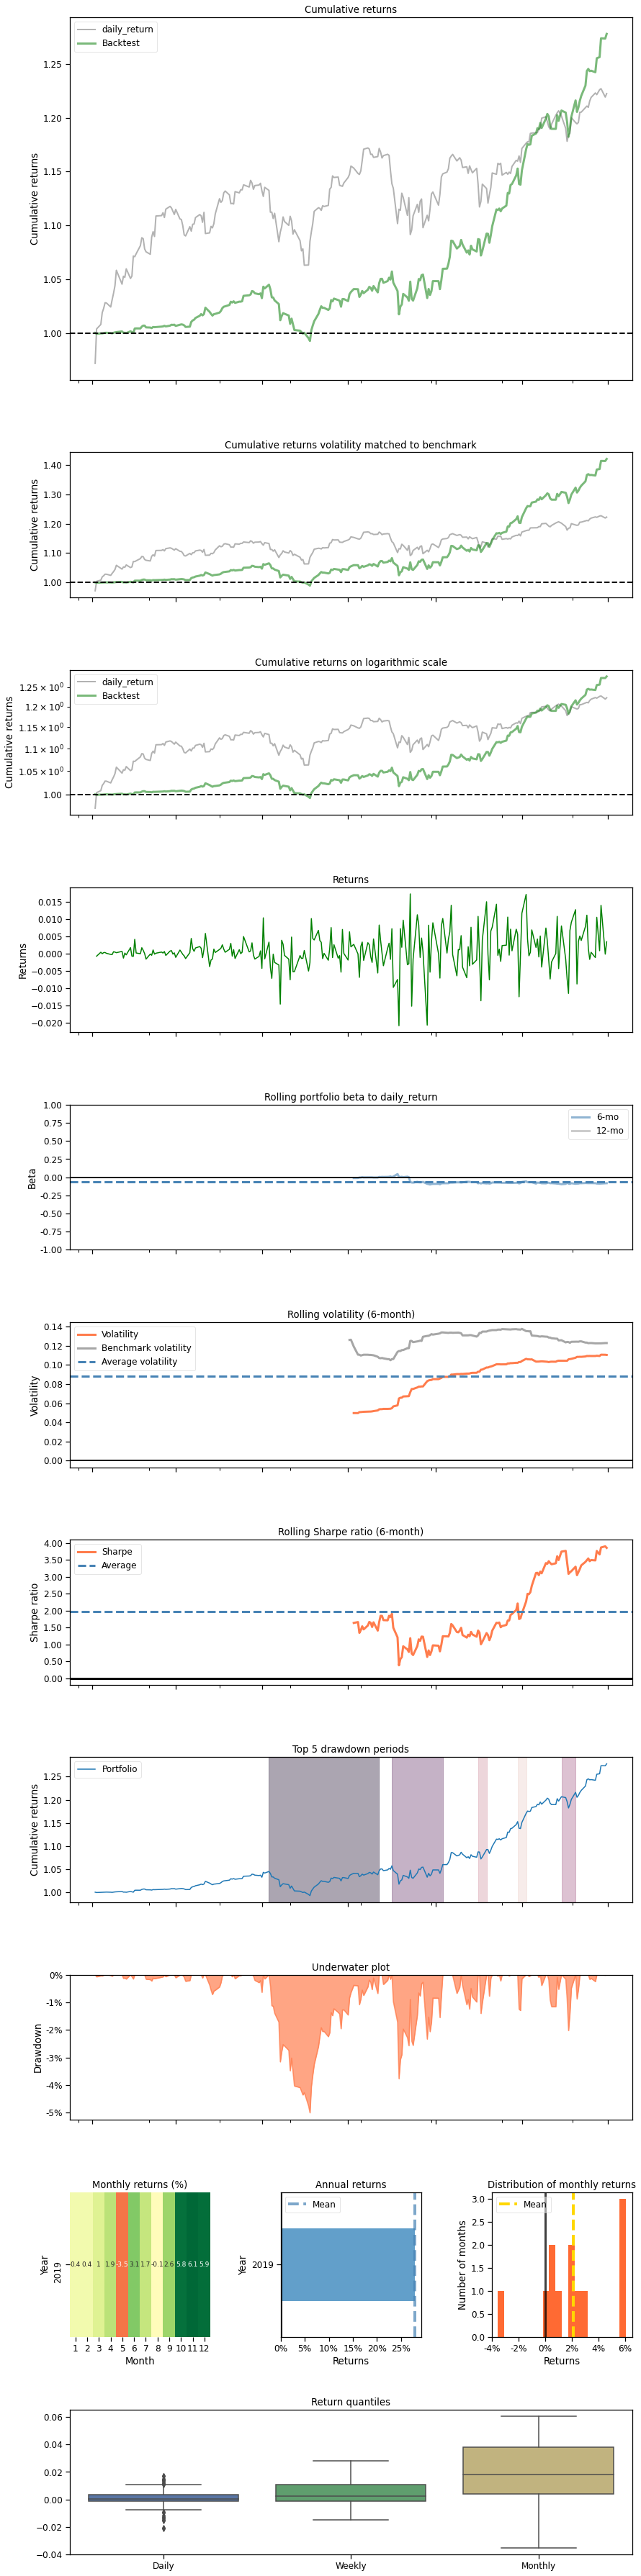

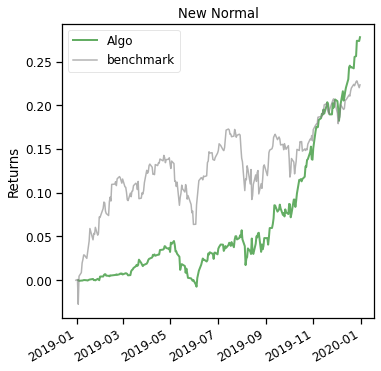

In [45]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-01-01', value_col_name = 'total_assets')